In [287]:
!pip install google-play-scraper
from google_play_scraper import app, reviews, Sort, reviews_all

import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import datetime as dt
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

!pip install sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from wordcloud import WordCloud

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [288]:
from google_play_scraper import reviews, Sort

scrapreview, _ = reviews(  # ← ambil hanya review-nya
    'com.tokopedia.tkpd',      # ID aplikasi Notion
    lang='id',                 # Bahasa Indonesia
    country='id',              # Negara Indonesia
    sort=Sort.MOST_RELEVANT,   # Urutkan berdasarkan ulasan paling relevan
    count=25000                # Jumlah ulasan yang diambil
)

In [289]:
# Menyimpan ulasan dalam file CSV
import csv

with open('ulasan_aplikasi.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['Review'])
    for review in scrapreview:
        writer.writerow([review['content']])

In [290]:
app_reviews_df = pd.DataFrame(scrapreview)
app_reviews_df.shape
app_reviews_df.head()
app_reviews_df.to_csv('ulasan_aplikasi.csv', index=False)

# Membuat DataFrame dari hasil scrapreview
app_reviews_df = pd.DataFrame(scrapreview)

# Menghitung jumlah baris dan kolom dalam DataFrame
jumlah_ulasan, jumlah_kolom = app_reviews_df.shape

In [291]:
# Menampilkan lima baris pertama dari DataFrame app_reviews_df
app_reviews_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,a801cb94-be3d-459b-9faa-ccb04fe97709,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"pantes kalian hampir bangkrut, cara kalian men...",1,186,3.304.0,2025-03-20 15:14:43,"Halo Toppers, terima kasih atas rating yang ka...",2025-03-20 15:47:04,3.304.0
1,82ab6537-5c22-4c9c-8c19-00f52a4c3612,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Makin kesini, makin nggak nyaman belanja di To...",2,0,3.304.0,2025-03-24 06:45:56,"Halo Toppers, terima kasih atas rating yang ka...",2025-03-24 07:07:01,3.304.0
2,8106eb5c-aaa4-49de-a2d6-64701826c6b3,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"aplikasi sering terjadi bug, ketika terjadi ma...",1,3,3.304.0,2025-04-02 11:00:57,"Hi Toppers, silakan sampaikan kritik/saran ata...",2025-04-02 11:27:03,3.304.0
3,98a606a6-be4f-4d28-bfe6-0f68cd27c445,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Kok otomatis bisa menyalurkan uang ke penjual ...,1,28,3.305.0,2025-03-29 16:34:08,"Halo Toppers, terima kasih atas rating yang ka...",2025-03-29 17:07:02,3.305.0
4,2cc834cc-6dac-4a3a-8d6f-190b353791a6,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Promo diskon yg ada di etalase tidak sama deng...,1,17,3.305.0,2025-04-01 02:41:30,"Hi Toppers, silakan sampaikan kritik/saran ata...",2025-04-01 03:00:09,3.305.0


In [292]:
# Menampilkan informasi tentang DataFrame app_reviews_df
app_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              25000 non-null  object        
 1   userName              25000 non-null  object        
 2   userImage             25000 non-null  object        
 3   content               25000 non-null  object        
 4   score                 25000 non-null  int64         
 5   thumbsUpCount         25000 non-null  int64         
 6   reviewCreatedVersion  18978 non-null  object        
 7   at                    25000 non-null  datetime64[ns]
 8   replyContent          18848 non-null  object        
 9   repliedAt             18848 non-null  datetime64[ns]
 10  appVersion            18978 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 2.1+ MB


In [293]:
# Filter data yang tidak null di semua kolom yang dibutuhkan
clean_df = app_reviews_df[
    app_reviews_df['reviewCreatedVersion'].notna() &
    app_reviews_df['appVersion'].notna() &
    app_reviews_df['replyContent'].notna() &
    app_reviews_df['repliedAt'].notna()
]

# Reset index
clean_df = clean_df.sample(n=15000, random_state=42).reset_index(drop=True)

In [294]:
# Menampilkan informasi tentang DataFrame app_reviews_df
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              15000 non-null  object        
 1   userName              15000 non-null  object        
 2   userImage             15000 non-null  object        
 3   content               15000 non-null  object        
 4   score                 15000 non-null  int64         
 5   thumbsUpCount         15000 non-null  int64         
 6   reviewCreatedVersion  15000 non-null  object        
 7   at                    15000 non-null  datetime64[ns]
 8   replyContent          15000 non-null  object        
 9   repliedAt             15000 non-null  datetime64[ns]
 10  appVersion            15000 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 1.3+ MB


In [295]:
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka

    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    return text

def casefoldingText(text): # Mengubah semua karakter dalam teks menjadi huruf kecil
    text = text.lower()
    return text

def tokenizingText(text): # Memecah atau membagi string, teks menjadi daftar token
    text = word_tokenize(text)
    return text

def filteringText(text): # Menghapus stopwords dalam teks
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text): # Mengurangi kata ke bentuk dasarnya yang menghilangkan imbuhan awalan dan akhiran atau ke akar kata
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Memecah teks menjadi daftar kata
    words = text.split()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def toSentence(list_words): # Mengubah daftar kata menjadi kalimat
    sentence = ' '.join(word for word in list_words)
    return sentence

In [296]:
slangwords = {
    "@": "di", "abis": "habis", "wtb": "beli", "wts": "jual", "wtt": "tukar", "bgt": "banget",
    "maks": "maksimal", "ckp": "cukup", "krn": "karena", "karna": "karena", "yg": "yang", "aja": "saja",
    "bikin": "membuat", "gabisa": "tidak bisa", "gak": "tidak", "ga": "tidak", "g": "tidak",
    "gitu": "seperti itu", "udah": "sudah", "udh": "sudah", "sdh": "sudah",
    "bener": "benar", "biar": "supaya", "sm": "sama", "dpt": "dapat", "tdk": "tidak", "tp": "tapi",
    "tpi": "tapi", "dr": "dari", "trs": "terus", "trus": "terus", "knp": "kenapa", "klo": "kalau",
    "kl": "kalau", "dlu": "dulu", "makasih": "terima kasih", "makasi": "terima kasih",
    "mksih": "terima kasih", "thx": "terima kasih", "thanks": "terima kasih",
    "btw": "ngomong-ngomong", "pls": "tolong", "log": "masuk", "sc": "screenshot",
    "gajelas": "tidak jelas", "bisa": "dapat", "nmr": "nomor", "dmn": "dimana", "td": "tadi",
    "jg": "juga", "jd": "jadi", "blm": "belum", "sy": "saya", "gw": "saya", "gua": "saya",
    "lu": "kamu", "loe": "kamu", "lo": "kamu", "mnt": "menit", "msh": "masih", "cm": "cuma",
    "skrg": "sekarang", "trnyata": "ternyata", "pgn": "ingin", "smpe": "sampai", "blg": "bilang",
    "kyk": "seperti", "mngkin": "mungkin", "kek": "seperti", "nyoba": "mencoba", "emg": "memang",
    "loker": "lowongan kerja", "mulu": "selalu", "make": "pakai", "pake": "pakai",
    "gimana": "bagaimana", "sampe": "sampai", "utk": "untuk", "gini": "begini", "doang": "saja",
    "ok": "oke", "good": "baik", "mantap": "bagus", "kerenn": "keren", "bgus": "bagus",
    "top": "terbaik", "mantull": "mantap", "semoga": "harap", "terimakasih": "terima kasih",
    "nyari": "mencari", "job": "pekerjaan", "kerja": "bekerja", "pekerjaan": "kerja",
    "bermanfaat": "berguna", "ilmu": "pengetahuan", "akses": "mengakses", "akun": "pengguna",
    "update": "pembaruan", "cod": "bayar di tempat", "dg": "dengan", "dgn": "dengan",
    "apk": "aplikasi", "nyampe": "sampai", "tgl": "tanggal", "toped": "tokopedia"
}


def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [297]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
clean_df['text_clean'] = clean_df['content'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentence)

In [298]:
clean_df

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,ea9a21f3-ab4f-4135-bfc7-f349747a3e66,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,sangat mudah dan cepat melalui ceria,5,0,3.304.0,2025-03-19 16:16:30,Terima kasih sudah mempercayakan Tokopedia seb...,2025-03-19 16:47:06,3.304.0,sangat mudah dan cepat melalui ceria,sangat mudah dan cepat melalui ceria,sangat mudah dan cepat melalui ceria,"[sangat, mudah, dan, cepat, melalui, ceria]","[mudah, cepat, ceria]",mudah cepat ceria
1,f8254eb1-c57a-485b-891b-54496195b848,MReza Amanda,https://play-lh.googleusercontent.com/a/ACg8oc...,Tokped tolong dong perbaiki lgi terkait sistem...,2,1,3.193,2022-10-06 16:27:32,"Hai Kak MReza, mohon maaf atas ketidaknyamanan...",2022-10-06 16:58:07,3.193,Tokped tolong dong perbaiki lgi terkait sistem...,tokped tolong dong perbaiki lgi terkait sistem...,tokped tolong dong perbaiki lgi terkait sistem...,"[tokped, tolong, dong, perbaiki, lgi, terkait,...","[tokped, tolong, perbaiki, lgi, terkait, siste...",tokped tolong perbaiki lgi terkait sistem baya...
2,4aa5935f-45c4-4fcb-a113-8ce15253359d,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"yg mengecewakan itu,jika kita akan mengajukan ...",3,29,3.4,2018-10-25 15:41:04,"Hai Santoso, mohon maaf atas ketidaknyamananny...",2018-10-26 02:17:05,3.4,yg mengecewakan itujika kita akan mengajukan k...,yg mengecewakan itujika kita akan mengajukan k...,yang mengecewakan itujika kita akan mengajukan...,"[yang, mengecewakan, itujika, kita, akan, meng...","[mengecewakan, itujika, mengajukan, komplain, ...",mengecewakan itujika mengajukan komplain fasil...
3,b709595b-0fe0-486f-a5b8-582f54fd400b,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,akun ku nggak pernah dapat diskon dan gratis o...,1,0,3.288.0,2024-11-11 01:43:54,"Hi Toppers, silakan sampaikan kritik/saran ata...",2024-11-11 01:58:11,3.288.0,akun ku nggak pernah dapat diskon dan gratis o...,akun ku nggak pernah dapat diskon dan gratis o...,pengguna ku nggak pernah dapat diskon dan grat...,"[pengguna, ku, nggak, pernah, dapat, diskon, d...","[pengguna, nggak, diskon, gratis, ongkir, sald...",pengguna nggak diskon gratis ongkir saldo tari...
4,5c52daa4-90f8-49f0-a892-b0f280b06fa1,Tas Shop,https://play-lh.googleusercontent.com/a/ACg8oc...,Dear tokopedia Mohon di jelaskan mengenai mode...,1,2,3.78.1,2020-06-16 03:06:02,Hai Kak Natalia. Maaf ya atas ketidaknyamanann...,2020-06-16 04:32:02,3.78.1,Dear tokopedia Mohon di jelaskan mengenai mode...,dear tokopedia mohon di jelaskan mengenai mode...,dear tokopedia mohon di jelaskan mengenai mode...,"[dear, tokopedia, mohon, di, jelaskan, mengena...","[dear, tokopedia, mohon, moderasi, toko, bbera...",dear tokopedia mohon moderasi toko bberapa x k...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,d8cc9e0b-9c13-47c6-8c23-9a7d3211df74,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"customer service lama, CS di media sosial juga...",1,0,3.301.1,2025-03-20 13:15:51,"Toppers, mohon maaf atas kendala yang kamu ala...",2025-03-20 13:20:05,3.301.1,customer service lama CS di media sosial juga ...,customer service lama cs di media sosial juga ...,customer service lama cs di media sosial juga ...,"[customer, service, lama, cs, di, media, sosia...","[customer, service, cs, media, sosial, andalka...",customer service cs media sosial andalkan kecewa
14996,b5bec6b4-b584-47a0-8a90-15affbc1881f,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"gausah deh ada kuri rekomendasi rekomendasi,. ...",1,0,3.292.0,2024-12-27 08:16:13,"Hi Toppers, silakan sampaikan kritik/saran ata...",2024-12-27 08:20:06,3.292.0,gausah deh ada kuri rekomendasi rekomendasi ma...,gausah deh ada kuri rekomendasi rekomendasi ma...,gausah deh ada kuri rekomendasi rekomendasi ma...,"[gausah,

In [299]:
import csv
import requests
from io import StringIO

# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_positive[row[0]] = int(row[1])
        # Menambahkan kata-kata positif dan skornya ke dalam kamus lexicon_positive
else:
    print("Failed to fetch positive lexicon data")

# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_negative[row[0]] = int(row[1])
        # Menambahkan kata-kata negatif dan skornya dalam kamus lexicon_negative
else:
    print("Failed to fetch negative lexicon data")

In [300]:
# Fungsi untuk menentukan polaritas sentimen dari tweet

def sentiment_analysis_lexicon_indonesia(text):
    #for word in text:

    score = 0
    # Inisialisasi skor sentimen ke 0

    for word in text:
        # Mengulangi setiap kata dalam teks

        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
            # Jika kata ada dalam kamus positif, tambahkan skornya ke skor sentimen

    for word in text:
        # Mengulangi setiap kata dalam teks (sekali lagi)

        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
            # Jika kata ada dalam kamus negatif, kurangkan skornya dari skor sentimen

    polarity=''
    # Inisialisasi variabel polaritas

    if (score >= 0):
        polarity = 'positive'
        # Jika skor sentimen lebih besar atau sama dengan 0, maka polaritas adalah positif
    elif (score < 0):
        polarity = 'negative'
        # Jika skor sentimen kurang dari 0, maka polaritas adalah negatif

    # else:
    #     polarity = 'neutral'
    # Ini adalah bagian yang bisa digunakan untuk menentukan polaritas netral jika diperlukan

    return score, polarity
    # Mengembalikan skor sentimen dan polaritas teks

In [301]:
results = clean_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
clean_df['polarity_score'] = results[0]
clean_df['polarity'] = results[1]
print(clean_df['polarity'].value_counts())

polarity
negative    7910
positive    7090
Name: count, dtype: int64


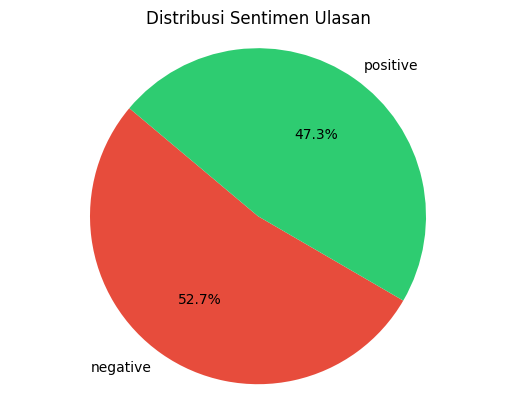

In [302]:
import matplotlib.pyplot as plt

# Hitung jumlah masing-masing polaritas
polarity_counts = clean_df['polarity'].value_counts()

# Data untuk pie chart
labels = polarity_counts.index
sizes = polarity_counts.values
colors = ['#e74c3c', '#2ecc71']  # hijau untuk positif, merah untuk negatif, kuning untuk netral
explode = [0.1 if label == 'positif' else 0 for label in labels]  # explode bagian 'positif'

# Buat pie chart
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    colors=colors,
    explode=explode,
    startangle=140
)

plt.title('Distribusi Sentimen Ulasan')
plt.axis('equal')  # Untuk membuat pie jadi bulat sempurna
plt.show()

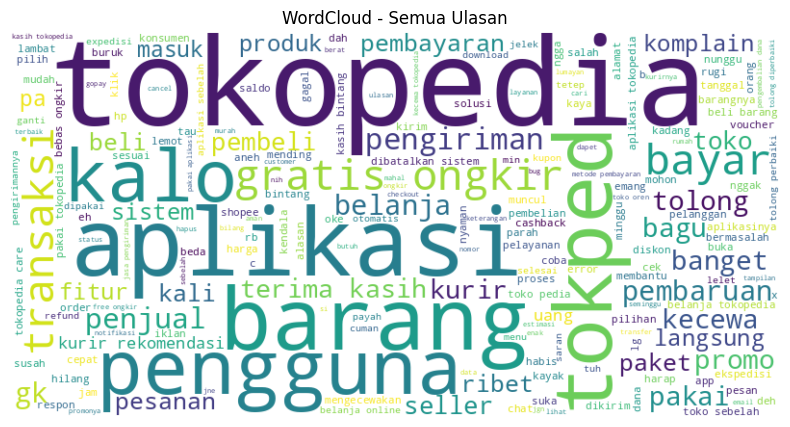

In [303]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Gabungkan semua teks ulasan yang telah dibersihkan
all_words = ' '.join([' '.join(words) for words in clean_df['text_stopword']])

# Buat WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

# Tampilkan
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - Semua Ulasan')
plt.show()

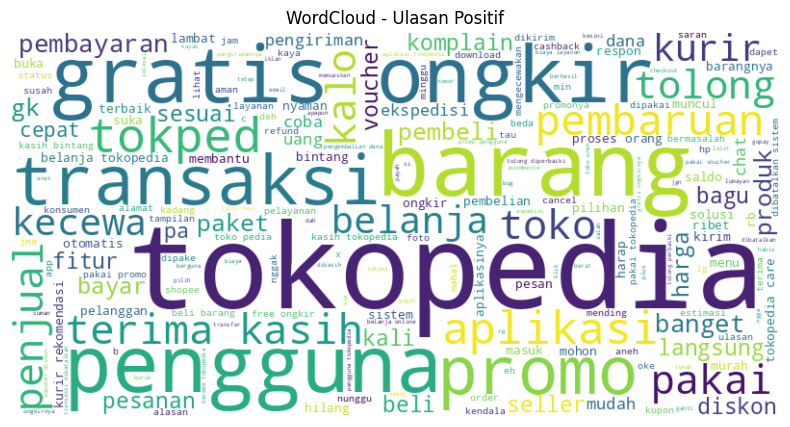

In [304]:
# Gabungkan kata-kata dari ulasan positif
positive_words = ' '.join([' '.join(words) for words in clean_df[clean_df['polarity'] == 'positive']['text_stopword']])

# Buat WordCloud positif
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_words)

# Tampilkan
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - Ulasan Positif')
plt.show()

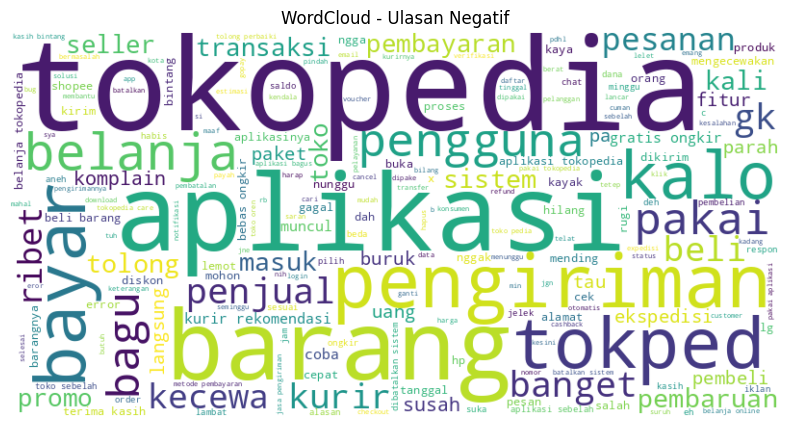

In [305]:
# Gabungkan kata-kata dari ulasan negatif
negative_words = ' '.join([' '.join(words) for words in clean_df[clean_df['polarity'] == 'negative']['text_stopword']])

# Buat WordCloud negatif
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_words)

# Tampilkan
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - Ulasan Negatif')
plt.show()

In [306]:
#Pisahkan data menjadi fitur (tweet) dan label (sentimen)
X = clean_df['text_akhir']
y = clean_df['polarity']

# Ekstraksi fitur dengan TF-IDF
tfidf = TfidfVectorizer(
    max_features=2500,
    min_df=17,
    max_df=0.8,
)

X_tfidf = tfidf.fit_transform(X)

# Konversi hasil ekstraksi fitur menjadi DataFrame (opsional, buat analisis visualisasi)
features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

# Bagi data menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

In [307]:
from sklearn.linear_model import LogisticRegression

# Membuat objek model Logistic Regression
logistic_regression = LogisticRegression(
    C=20,
    max_iter=1000,
)

# Melatih model Logistic Regression pada data pelatihan
logistic_regression.fit(X_train.toarray(), y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_lr = logistic_regression.predict(X_train.toarray())
y_pred_test_lr = logistic_regression.predict(X_test.toarray())

# Evaluasi akurasi model Logistic Regression pada data pelatihan
accuracy_train_lr = accuracy_score(y_pred_train_lr, y_train)

# Evaluasi akurasi model Logistic Regression pada data uji
accuracy_test_lr = accuracy_score(y_pred_test_lr, y_test)

# Menampilkan akurasi
print('Logistic Regression - accuracy_train:', accuracy_train_lr)
print('Logistic Regression - accuracy_test:', accuracy_test_lr)

Logistic Regression - accuracy_train: 0.96675
Logistic Regression - accuracy_test: 0.9073333333333333
